In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns

#import pydicom
import time
import gc
import operator 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 8153
#device=device_by_name("Tesla")
device=device_by_name("RTX")
#device=device_by_name("1060")
torch.cuda.set_device(device)
#device = "cpu"
sendmeemail=Email_Progress(my_gmail,my_pass,to_email,'Densenet161-Copy2-2 results')

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
def get_submission_ids(image_ids,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [5]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df.shape
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df=train_df.drop_duplicates().reset_index(drop=True)
train_df.shape
train_df.head()

(674510, 15)

(674252, 15)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [6]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [7]:
split_sid = train_df.PID.unique()
splits=list(KFold(n_splits=3,shuffle=True, random_state=SEED).split(split_sid))


In [8]:
def my_loss(y_pred,y_true,weights):
    window=(y_true>=0).to(torch.float)
    loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*weights.expand_as(y_true)).mean()
    return loss

In [9]:
class Metric():
    def __init__(self,weights,k=0.03):
        self.weights=weights
        self.k=k
        self.zero()
        
    def zero(self):
        self.loss_sum=0.
        self.loss_count=0.
        self.lossf=0.
        
    def calc(self,y_pred,y_true,prefix=""):
        window=(y_true>=0).to(torch.float)
        loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*self.weights.expand_as(y_true)).mean()/(window.mean()+1e-5)
        self.lossf=self.lossf*(1-self.k)+loss*self.k
        self.loss_sum=self.loss_sum+loss*window.sum()
        self.loss_count=self.loss_count+window.sum()
        return({prefix+'mloss':self.lossf})    
        
    def calc_sums(self,prefix=""):
        return({prefix+'mloss_tot':self.loss_sum/self.loss_count})    



In [10]:
#features=(features-features.mean())/features.std()

In [11]:
class SimpleModel(nn.Module):
    def __init__(self,in_size):
        super(SimpleModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (7,in_size), padding=(3,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 5, padding=2)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 3, padding=1)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(64, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [12]:
class SimpleModel2(nn.Module):
    def __init__(self,in_size):
        super(SimpleModel2, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(64, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [13]:
class ClassModel(nn.Module):
    def __init__(self,in_size):
        super(ClassModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(128, 6, 3, padding=1)
        
        self.conv2d1class=torch.nn.Conv2d(1, 128, (9,in_size), padding=(4,0))
        self.bn0class=torch.nn.BatchNorm1d(128)
        self.maxpool1class=torch.nn.MaxPool1d(3)
        self.conv1d1class=torch.nn.Conv1d(128, 128, 3, padding=1)
        self.bn1class=torch.nn.BatchNorm1d(128)
        self.maxpool2class=torch.nn.MaxPool1d(3)
        self.conv1d2class=torch.nn.Conv1d(128, 64, 2, padding=1)
        self.bn2class=torch.nn.BatchNorm1d(64)

        
        
    def forward(self, x):
        z=x
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        z=self.conv2d1class(z.unsqueeze(1)).squeeze(-1)
        z=self.bn0class(z)
        z=self.maxpool1class(z)
        z=self.conv1d1class(z)
        z=self.maxpool2class(z)
        z=self.conv1d2class(z)
        z=self.bn2class(z)
        z=F.max_pool1d(z,kernel_size=z.shape[-1])
        z=z.expand_as(x)
        x=torch.cat([x,z],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [14]:
class ResModel(nn.Module):
    def __init__(self,in_size):
        super(ResModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [15]:
class ResDropModel(nn.Module):
    def __init__(self,in_size,dropout=0.2):
        super(ResDropModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        self.dropout=dropout
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = F.dropout(x,self.dropout)
        x0 = self.relu0(x) 
        x = self.conv1d1(x0)
#        x = self.bn1(x)
        x = F.dropout(x,self.dropout)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
#        x = self.bn2(x)
        x = F.dropout(x,self.dropout)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        x = F.dropout(x,self.dropout)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [16]:
class ResModelIN(nn.Module):
    def __init__(self,in_size):
        super(ResModelIN, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.InstanceNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.InstanceNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.InstanceNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [17]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (5,2208), padding=(2,0))
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 6, 1)

        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.relu0(x)
        out = self.conv1d1(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


torch.Size([2697008, 552])

torch.Size([674252, 4, 552])

<IPython.core.display.Javascript object>


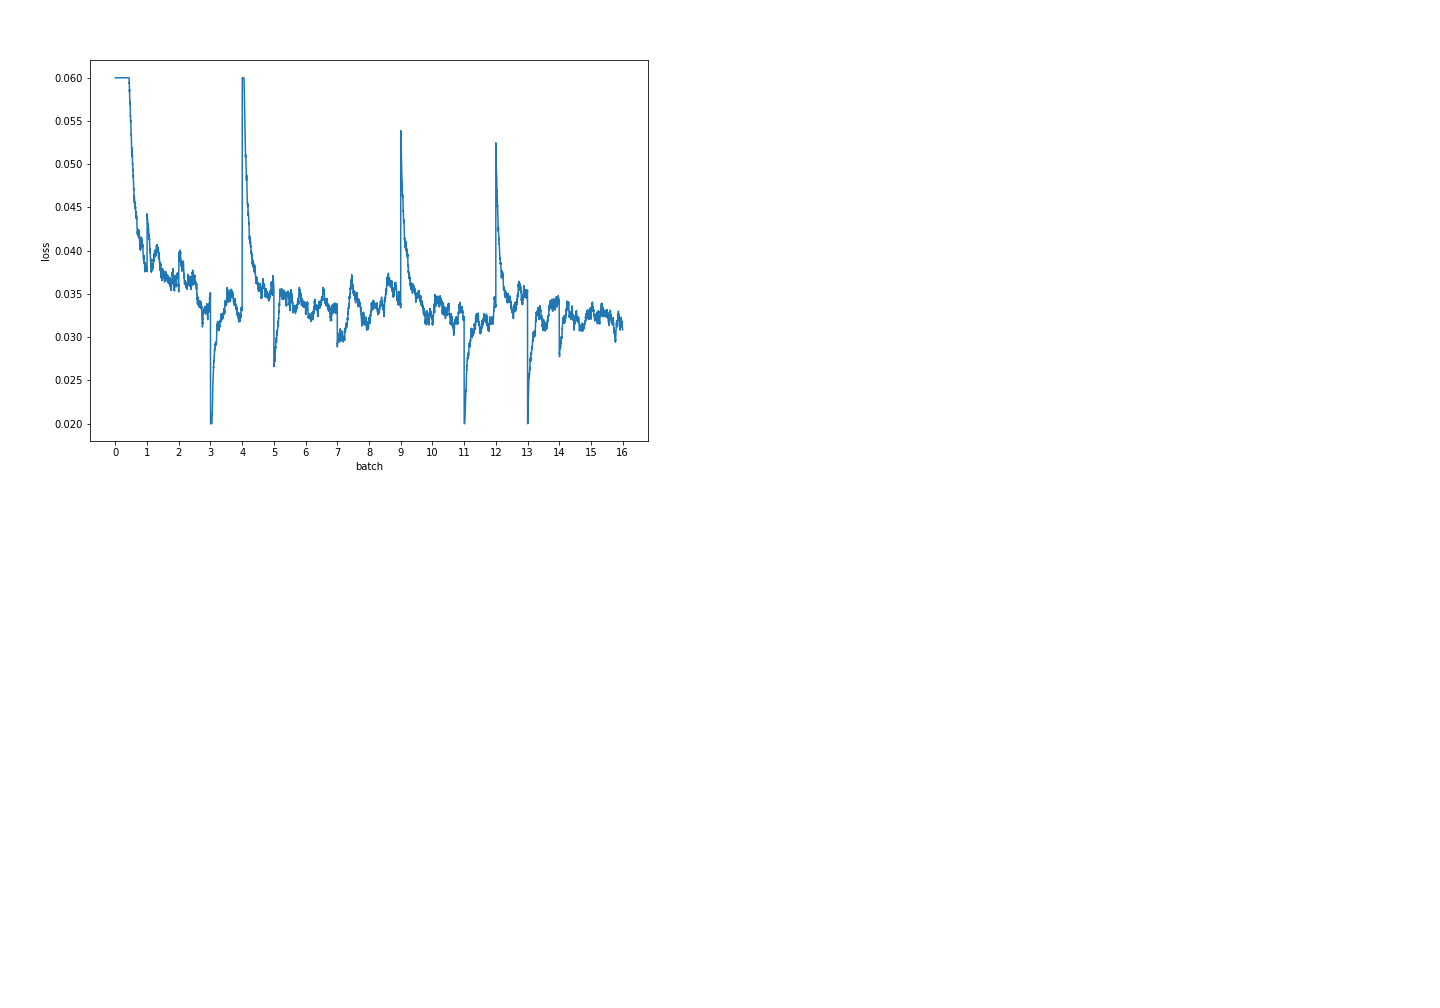

{'loss': 0.037599927387082156, 'mloss': tensor(0.0635), 'val_loss': 0.042692600850364554, 'val_mloss_tot': tensor(0.0740)}


{'loss': 0.03523342027866336, 'mloss': tensor(0.0564), 'val_loss': 0.04163088200824895, 'val_mloss_tot': tensor(0.0722)}


{'loss': 0.034960862629192256, 'mloss': tensor(0.0639), 'val_loss': 0.0412559283328394, 'val_mloss_tot': tensor(0.0715)}


{'loss': 0.033293354866938595, 'mloss': tensor(0.0596), 'val_loss': 0.041156812793497234, 'val_mloss_tot': tensor(0.0714)}


{'loss': 0.03556530921345387, 'mloss': tensor(0.0607), 'val_loss': 0.043991375001138214, 'val_mloss_tot': tensor(0.0763)}


{'loss': 0.03352124620095033, 'mloss': tensor(0.0576), 'val_loss': 0.04142735533306164, 'val_mloss_tot': tensor(0.0718)}


{'loss': 0.033230878529233766, 'mloss': tensor(0.0573), 'val_loss': 0.04100927188671354, 'val_mloss_tot': tensor(0.0711)}


{'loss': 0.03163538766444539, 'mloss': tensor(0.0560), 'val_loss': 0.04091087549011879, 'val_mloss_tot': tensor(0.0709)}


{'loss': 0.03343515987473534, 'mloss': tensor(0.0554), 'val_loss': 0.0414594910669558, 'val_mloss_tot': tensor(0.0719)}


{'loss': 0.031549682368763876, 'mloss': tensor(0.0522), 'val_loss': 0.04091242456973847, 'val_mloss_tot': tensor(0.0709)}


{'loss': 0.03237044013321535, 'mloss': tensor(0.0557), 'val_loss': 0.04076477549878394, 'val_mloss_tot': tensor(0.0707)}


{'loss': 0.033500690559540046, 'mloss': tensor(0.0581), 'val_loss': 0.040567436319743765, 'val_mloss_tot': tensor(0.0703)}


{'loss': 0.03517206913528462, 'mloss': tensor(0.0620), 'val_loss': 0.041931736044438894, 'val_mloss_tot': tensor(0.0727)}


{'loss': 0.03417802246571619, 'mloss': tensor(0.0594), 'val_loss': 0.041970328950859934, 'val_mloss_tot': tensor(0.0728)}


{'loss': 0.03265489170696984, 'mloss': tensor(0.0559), 'val_loss': 0.0409386638044999, 'val_mloss_tot': tensor(0.0710)}


{'loss': 0.030883931982904775, 'mloss': tensor(0.0515), 'val_loss': 0.04067272017939301, 'val_mloss_tot': tensor(0.0705)}




0.040567436319743765


In [18]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet161_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 552])

torch.Size([674252, 4, 552])

<IPython.core.display.Javascript object>


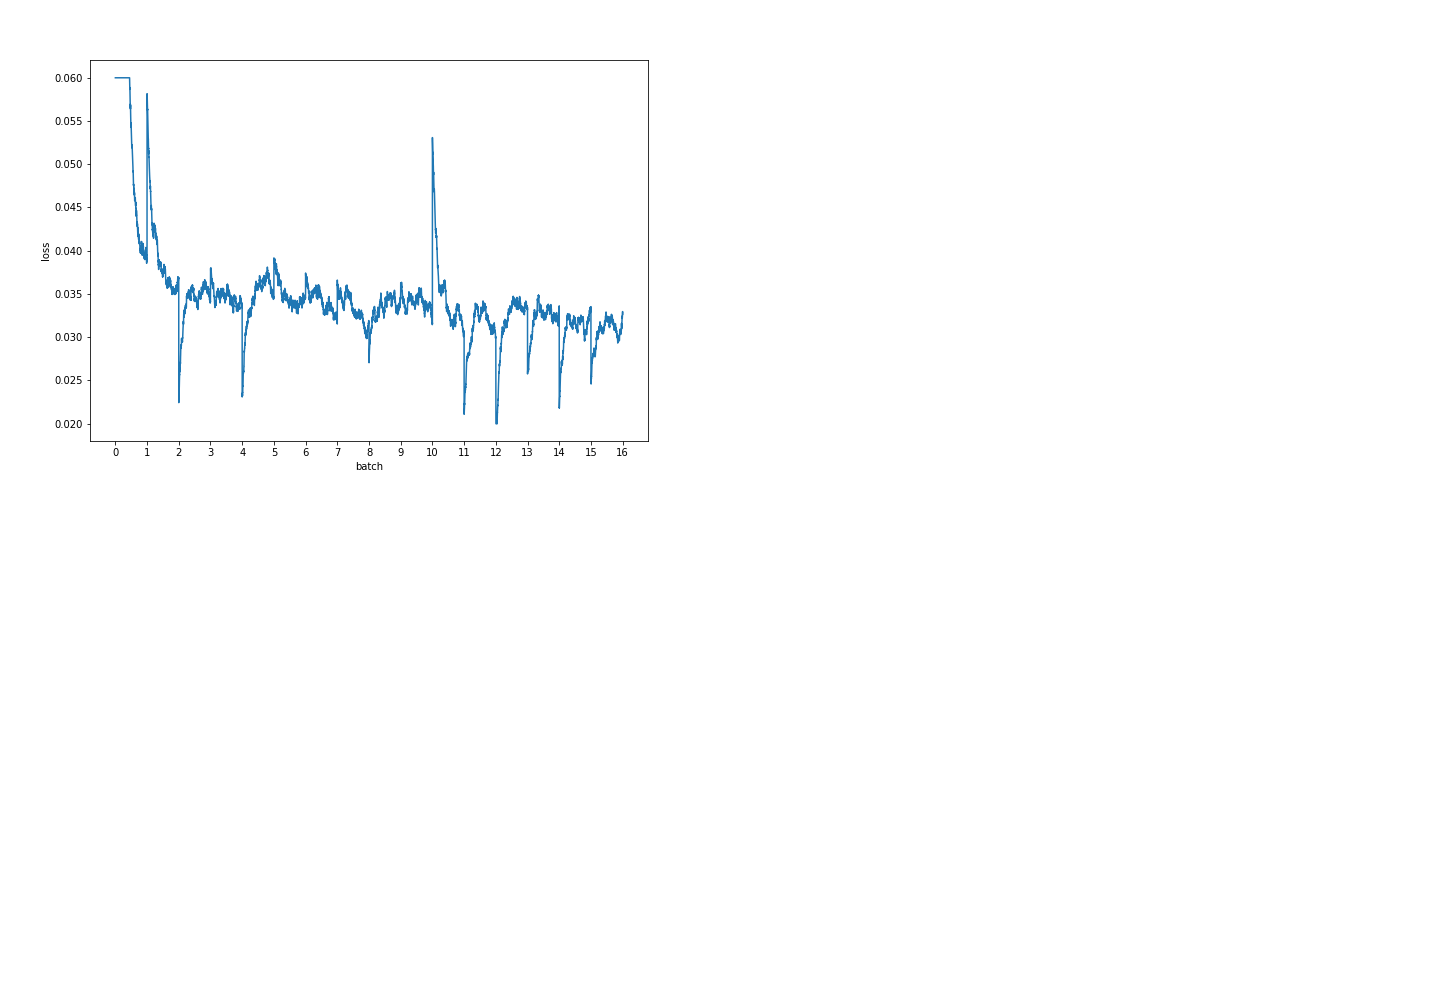

{'loss': 0.03950040773580641, 'mloss': tensor(0.0694), 'val_loss': 0.047720540763369845, 'val_mloss_tot': tensor(0.0829)}


{'loss': 0.036755158692868536, 'mloss': tensor(0.0648), 'val_loss': 0.0444650539573227, 'val_mloss_tot': tensor(0.0772)}


{'loss': 0.03419218235042163, 'mloss': tensor(0.0577), 'val_loss': 0.04696940028526146, 'val_mloss_tot': tensor(0.0815)}


{'loss': 0.03361808883782167, 'mloss': tensor(0.0578), 'val_loss': 0.04377561550371789, 'val_mloss_tot': tensor(0.0760)}


{'loss': 0.034609590880388716, 'mloss': tensor(0.0589), 'val_loss': 0.044171261227244664, 'val_mloss_tot': tensor(0.0767)}


{'loss': 0.035126038660491875, 'mloss': tensor(0.0626), 'val_loss': 0.04491483148421376, 'val_mloss_tot': tensor(0.0780)}


{'loss': 0.0315288329791351, 'mloss': tensor(0.0519), 'val_loss': 0.04433411568875787, 'val_mloss_tot': tensor(0.0770)}


{'loss': 0.03152678205105637, 'mloss': tensor(0.0562), 'val_loss': 0.04306698100311049, 'val_mloss_tot': tensor(0.0748)}


{'loss': 0.030361746621584668, 'mloss': tensor(0.0502), 'val_loss': 0.04958959986006135, 'val_mloss_tot': tensor(0.0861)}


{'loss': 0.029869236809107004, 'mloss': tensor(0.0492), 'val_loss': 0.043013612970278545, 'val_mloss_tot': tensor(0.0747)}


{'loss': 0.033209777757520195, 'mloss': tensor(0.0569), 'val_loss': 0.04366485486460822, 'val_mloss_tot': tensor(0.0758)}


{'loss': 0.033623629733739974, 'mloss': tensor(0.0639), 'val_loss': 0.042719581969577834, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.03334074160011046, 'mloss': tensor(0.0603), 'val_loss': 0.050120192284012224, 'val_mloss_tot': tensor(0.0870)}


{'loss': 0.03264786546649227, 'mloss': tensor(0.0608), 'val_loss': 0.04381069853234339, 'val_mloss_tot': tensor(0.0761)}




0.042719581969577834


In [19]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet161_3' , 'classifier_splits',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 552])

torch.Size([674252, 4, 552])

<IPython.core.display.Javascript object>


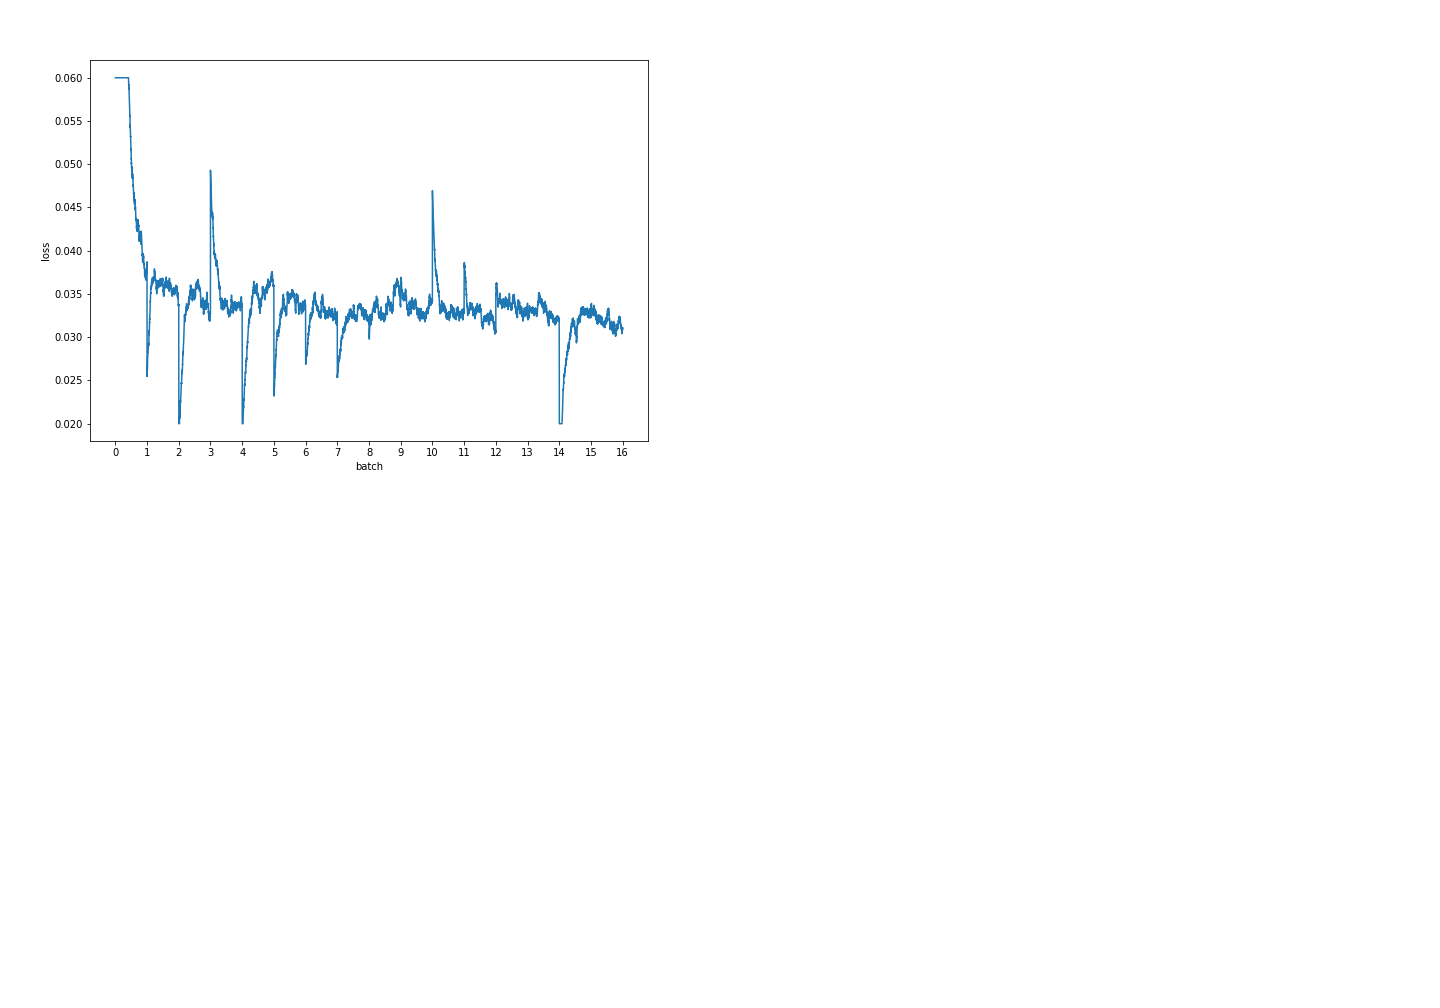

{'loss': 0.038714805346466735, 'mloss': tensor(0.0709), 'val_loss': 0.045096054492609165, 'val_mloss_tot': tensor(0.0787)}


{'loss': 0.03363656240554088, 'mloss': tensor(0.0546), 'val_loss': 0.043573513878055095, 'val_mloss_tot': tensor(0.0761)}


{'loss': 0.03312544503789337, 'mloss': tensor(0.0594), 'val_loss': 0.04322016567514255, 'val_mloss_tot': tensor(0.0754)}


{'loss': 0.03353480621519787, 'mloss': tensor(0.0571), 'val_loss': 0.04230061982440331, 'val_mloss_tot': tensor(0.0738)}


{'loss': 0.03543000511928441, 'mloss': tensor(0.0581), 'val_loss': 0.04334412531631931, 'val_mloss_tot': tensor(0.0757)}


{'loss': 0.03324061060581472, 'mloss': tensor(0.0559), 'val_loss': 0.04237787972386109, 'val_mloss_tot': tensor(0.0740)}


{'loss': 0.03296664527017772, 'mloss': tensor(0.0609), 'val_loss': 0.04205274767719391, 'val_mloss_tot': tensor(0.0734)}


{'loss': 0.031957432061373935, 'mloss': tensor(0.0550), 'val_loss': 0.04221124858822583, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.03409656263737818, 'mloss': tensor(0.0569), 'val_loss': 0.04333871334177874, 'val_mloss_tot': tensor(0.0757)}


{'loss': 0.03418446031372028, 'mloss': tensor(0.0596), 'val_loss': 0.0423685237186075, 'val_mloss_tot': tensor(0.0739)}


{'loss': 0.03324898171819445, 'mloss': tensor(0.0592), 'val_loss': 0.04222645787862925, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.030795853139567418, 'mloss': tensor(0.0528), 'val_loss': 0.04218511927259586, 'val_mloss_tot': tensor(0.0736)}


{'loss': 0.03384207928767631, 'mloss': tensor(0.0619), 'val_loss': 0.04254329730529429, 'val_mloss_tot': tensor(0.0743)}


{'loss': 0.031895458146896316, 'mloss': tensor(0.0550), 'val_loss': 0.04314424389428118, 'val_mloss_tot': tensor(0.0753)}


{'loss': 0.03242389315325314, 'mloss': tensor(0.0555), 'val_loss': 0.04222744109177189, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.03092485247409137, 'mloss': tensor(0.0531), 'val_loss': 0.0422731090615299, 'val_mloss_tot': tensor(0.0738)}




0.04205274767719391


In [20]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet161_3' , 'classifier_splits',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 208])

torch.Size([674252, 4, 208])

<IPython.core.display.Javascript object>


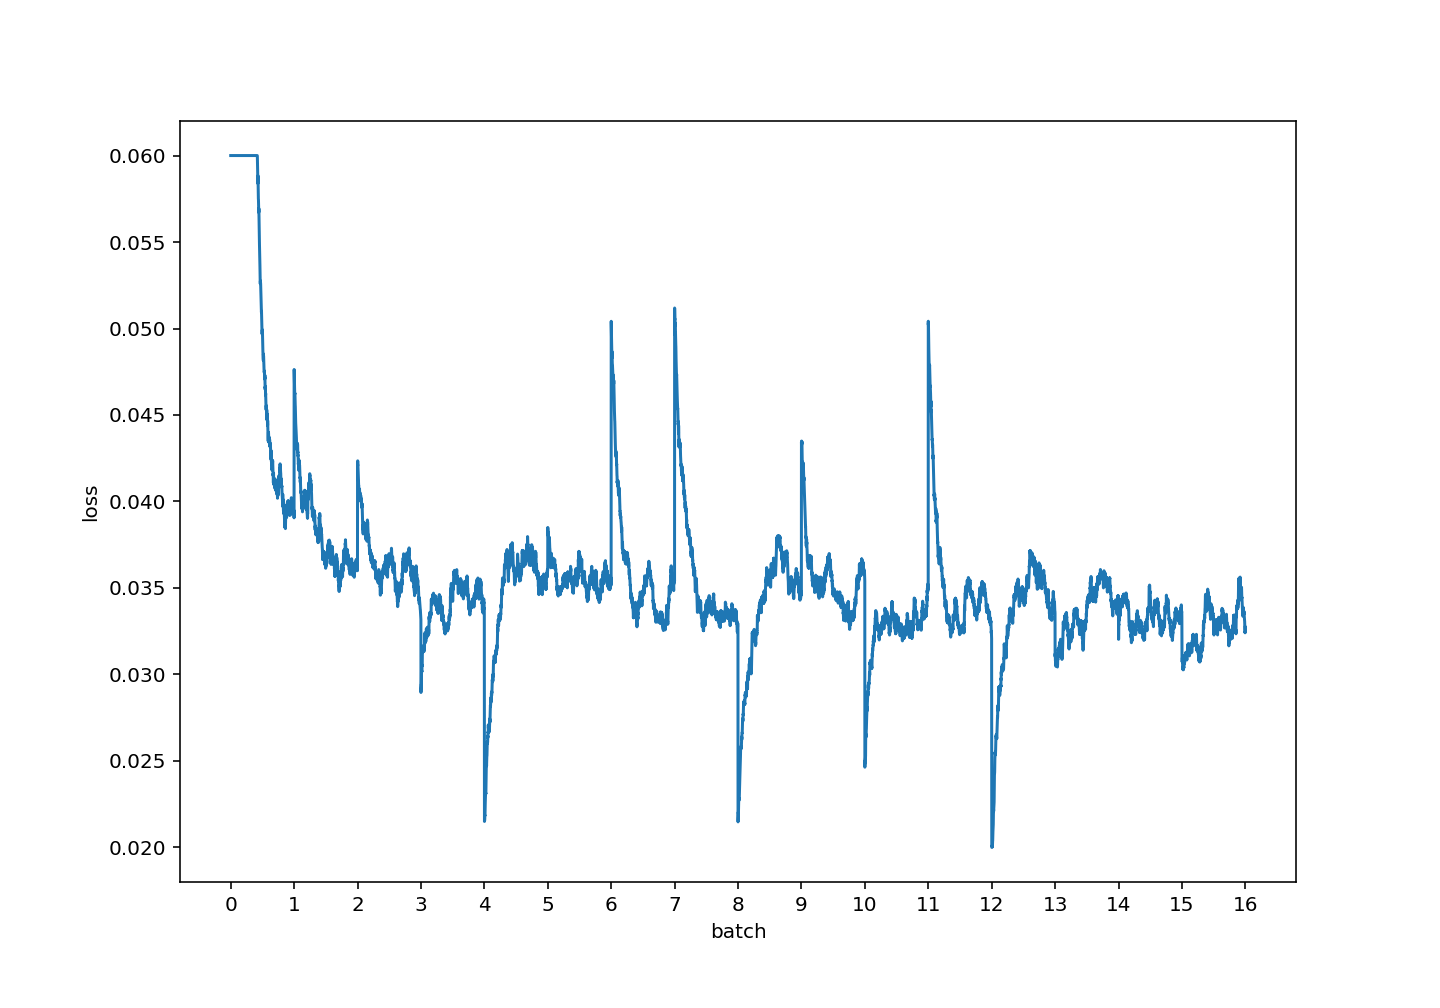

{'loss': 0.03905433233726299, 'mloss': tensor(0.0666), 'val_loss': 0.043858949497069526, 'val_mloss_tot': tensor(0.0766)}


{'loss': 0.0360009106195948, 'mloss': tensor(0.0619), 'val_loss': 0.04279235221627282, 'val_mloss_tot': tensor(0.0747)}


{'loss': 0.03316826980073802, 'mloss': tensor(0.0531), 'val_loss': 0.04249205189393606, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.033834061485788, 'mloss': tensor(0.0567), 'val_loss': 0.0422168392381381, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.03631912719128076, 'mloss': tensor(0.0661), 'val_loss': 0.04238555332782065, 'val_mloss_tot': tensor(0.0740)}


{'loss': 0.03537440934504035, 'mloss': tensor(0.0616), 'val_loss': 0.04200664952556353, 'val_mloss_tot': tensor(0.0733)}


{'loss': 0.03540672800592649, 'mloss': tensor(0.0620), 'val_loss': 0.04191385311324422, 'val_mloss_tot': tensor(0.0732)}


{'loss': 0.03262027509826248, 'mloss': tensor(0.0546), 'val_loss': 0.04210202767877135, 'val_mloss_tot': tensor(0.0735)}


{'loss': 0.0348861593442544, 'mloss': tensor(0.0605), 'val_loss': 0.04372608801122846, 'val_mloss_tot': tensor(0.0763)}


{'loss': 0.035389432054320866, 'mloss': tensor(0.0601), 'val_loss': 0.042202868291017846, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.035006254844227425, 'mloss': tensor(0.0648), 'val_loss': 0.042179281645022874, 'val_mloss_tot': tensor(0.0736)}


{'loss': 0.0320511460981923, 'mloss': tensor(0.0513), 'val_loss': 0.04188214870078898, 'val_mloss_tot': tensor(0.0731)}


{'loss': 0.03352312963074439, 'mloss': tensor(0.0564), 'val_loss': 0.04323192452216839, 'val_mloss_tot': tensor(0.0755)}


{'loss': 0.033805822057436465, 'mloss': tensor(0.0578), 'val_loss': 0.04252767427881225, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.033324809130247414, 'mloss': tensor(0.0571), 'val_loss': 0.042113713817898094, 'val_mloss_tot': tensor(0.0735)}


{'loss': 0.032728920556688385, 'mloss': tensor(0.0535), 'val_loss': 0.042146337612691084, 'val_mloss_tot': tensor(0.0736)}




0.04188214870078898


In [22]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet169_3' , 'classifier_splits',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 240])

torch.Size([674252, 4, 240])

<IPython.core.display.Javascript object>


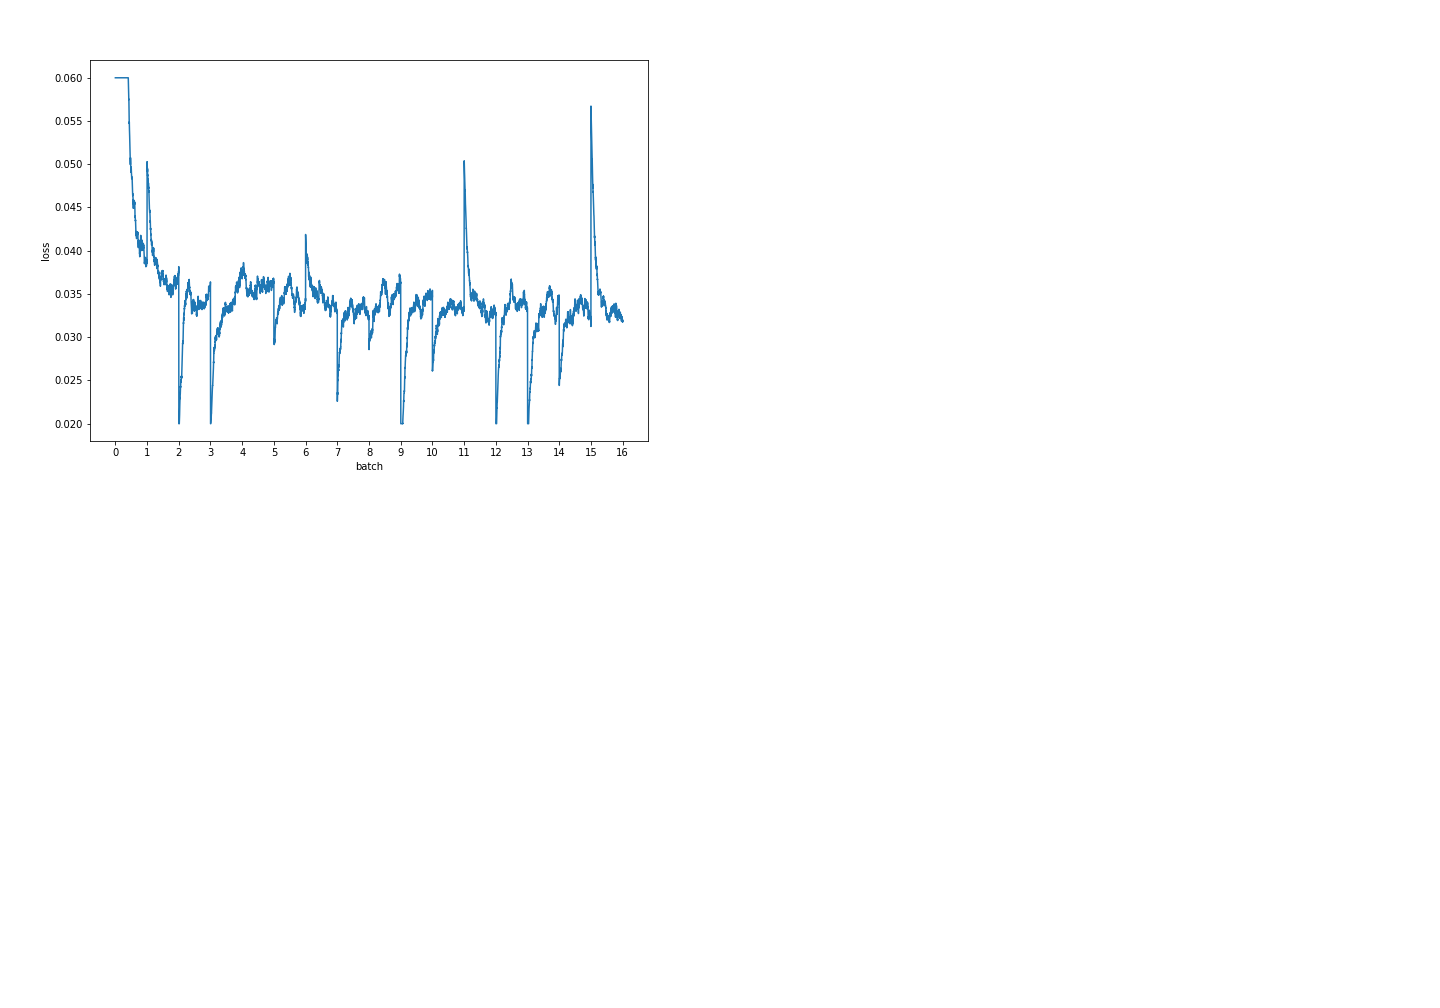

{'loss': 0.038859921326575814, 'mloss': tensor(0.0688), 'val_loss': 0.04626369767414011, 'val_mloss_tot': tensor(0.0803)}


{'loss': 0.038162344728192965, 'mloss': tensor(0.0711), 'val_loss': 0.04369450832850167, 'val_mloss_tot': tensor(0.0759)}


{'loss': 0.03639597625649562, 'mloss': tensor(0.0664), 'val_loss': 0.043223883651582334, 'val_mloss_tot': tensor(0.0750)}


{'loss': 0.0367543412272333, 'mloss': tensor(0.0626), 'val_loss': 0.04324113856656982, 'val_mloss_tot': tensor(0.0751)}


{'loss': 0.03642151815246103, 'mloss': tensor(0.0639), 'val_loss': 0.04367242765778061, 'val_mloss_tot': tensor(0.0758)}


{'loss': 0.03416251832174848, 'mloss': tensor(0.0612), 'val_loss': 0.043285821583993696, 'val_mloss_tot': tensor(0.0751)}


{'loss': 0.0328912585077691, 'mloss': tensor(0.0557), 'val_loss': 0.04319522321439839, 'val_mloss_tot': tensor(0.0750)}


{'loss': 0.032506232609781235, 'mloss': tensor(0.0554), 'val_loss': 0.04294171487669383, 'val_mloss_tot': tensor(0.0746)}


{'loss': 0.03606212879481145, 'mloss': tensor(0.0617), 'val_loss': 0.043725709856391466, 'val_mloss_tot': tensor(0.0759)}


{'loss': 0.03542246104700155, 'mloss': tensor(0.0640), 'val_loss': 0.04280878373953913, 'val_mloss_tot': tensor(0.0743)}


{'loss': 0.03439772234552472, 'mloss': tensor(0.0640), 'val_loss': 0.042687425861281936, 'val_mloss_tot': tensor(0.0741)}


{'loss': 0.03280222298758221, 'mloss': tensor(0.0563), 'val_loss': 0.042755331833768874, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.03296866824016371, 'mloss': tensor(0.0550), 'val_loss': 0.04426294222320407, 'val_mloss_tot': tensor(0.0769)}


{'loss': 0.03457979648201321, 'mloss': tensor(0.0624), 'val_loss': 0.042586660848728614, 'val_mloss_tot': tensor(0.0739)}


{'loss': 0.031243936197512423, 'mloss': tensor(0.0500), 'val_loss': 0.04327675345149625, 'val_mloss_tot': tensor(0.0751)}


{'loss': 0.031818152969584027, 'mloss': tensor(0.0536), 'val_loss': 0.04284109750400146, 'val_mloss_tot': tensor(0.0744)}




(0.0424090467939346, {'val_loss': 0.0424090467939346, 'val_mloss_tot': tensor(0.0736)})


In [23]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet201_3' , 'classifier_splits',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 240])

torch.Size([674252, 4, 240])

<IPython.core.display.Javascript object>


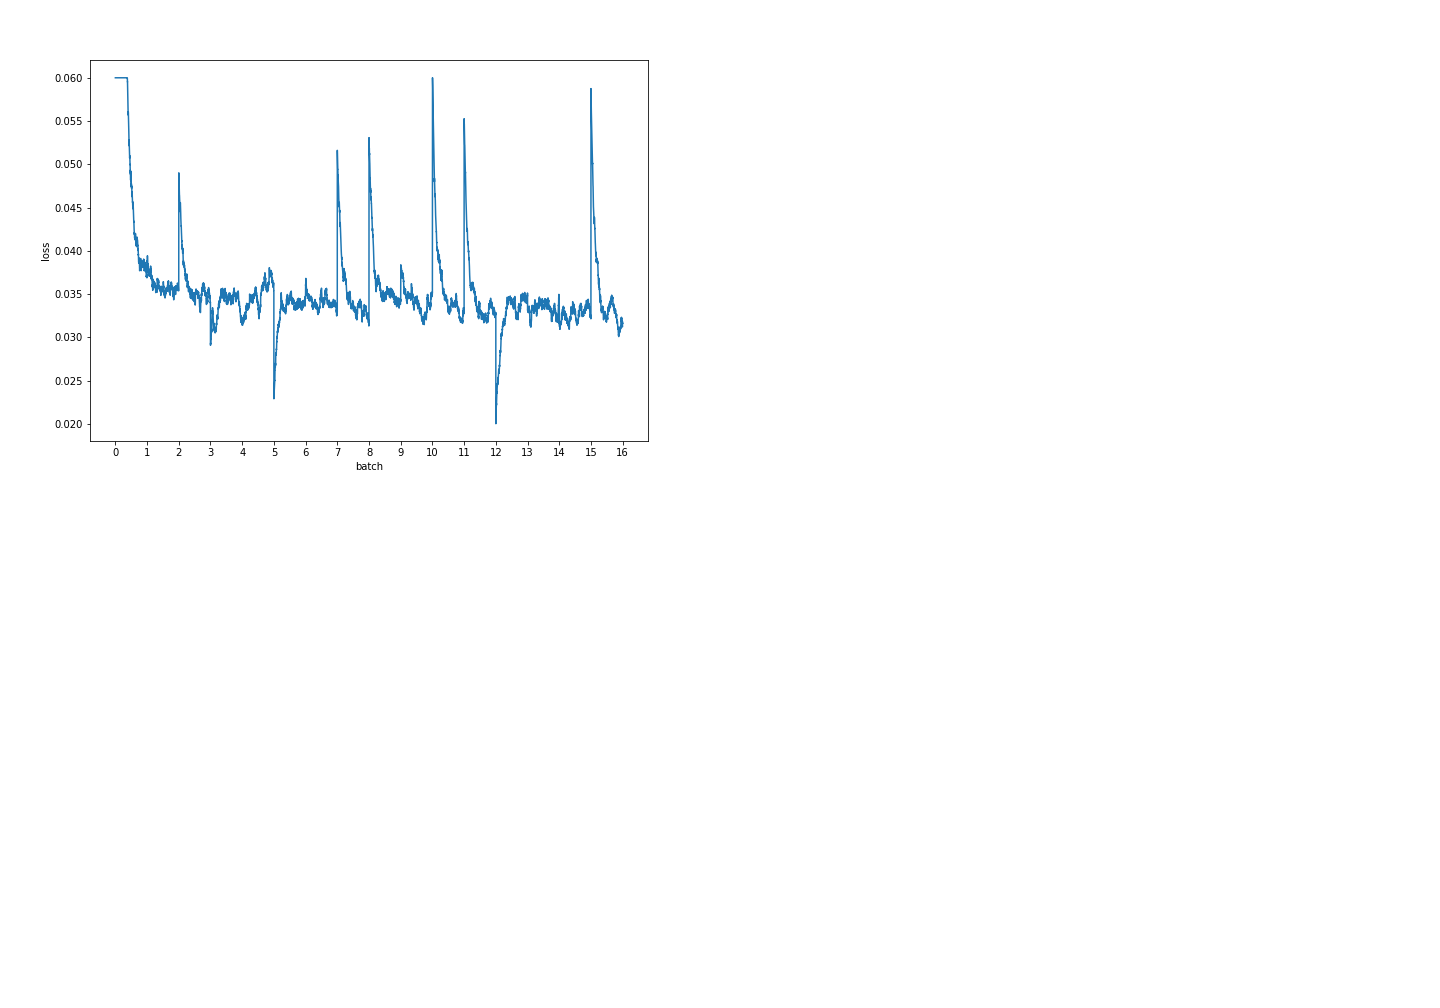

{'loss': 0.037240860337385606, 'mloss': tensor(0.0634), 'val_loss': 0.04368565802848557, 'val_mloss_tot': tensor(0.0762)}


{'loss': 0.03582790881991568, 'mloss': tensor(0.0619), 'val_loss': 0.04351817122547001, 'val_mloss_tot': tensor(0.0760)}


{'loss': 0.033728079310718584, 'mloss': tensor(0.0552), 'val_loss': 0.04225344883346158, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.03143706021953008, 'mloss': tensor(0.0513), 'val_loss': 0.04222139647434943, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.03539086122234837, 'mloss': tensor(0.0581), 'val_loss': 0.04337291130114619, 'val_mloss_tot': tensor(0.0757)}


{'loss': 0.03495973243966455, 'mloss': tensor(0.0631), 'val_loss': 0.04247056451149103, 'val_mloss_tot': tensor(0.0741)}


{'loss': 0.032931653250453594, 'mloss': tensor(0.0557), 'val_loss': 0.04281518328253452, 'val_mloss_tot': tensor(0.0747)}


{'loss': 0.03171383297045466, 'mloss': tensor(0.0528), 'val_loss': 0.04215376693073933, 'val_mloss_tot': tensor(0.0736)}


{'loss': 0.03415696261155764, 'mloss': tensor(0.0593), 'val_loss': 0.04347936893904173, 'val_mloss_tot': tensor(0.0759)}


{'loss': 0.035134454020093214, 'mloss': tensor(0.0632), 'val_loss': 0.04253129531379517, 'val_mloss_tot': tensor(0.0742)}


{'loss': 0.03317408291560055, 'mloss': tensor(0.0597), 'val_loss': 0.04224145162918764, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.03242212891901487, 'mloss': tensor(0.0547), 'val_loss': 0.04221961973689315, 'val_mloss_tot': tensor(0.0737)}


{'loss': 0.034995150872342694, 'mloss': tensor(0.0620), 'val_loss': 0.04203325960012834, 'val_mloss_tot': tensor(0.0734)}


{'loss': 0.03461694118375926, 'mloss': tensor(0.0647), 'val_loss': 0.04207639492162299, 'val_mloss_tot': tensor(0.0734)}


{'loss': 0.03231621115188533, 'mloss': tensor(0.0538), 'val_loss': 0.04262997533944322, 'val_mloss_tot': tensor(0.0744)}


{'loss': 0.03159527346589534, 'mloss': tensor(0.0548), 'val_loss': 0.04216668739710457, 'val_mloss_tot': tensor(0.0736)}




(0.04187546223742751, {'val_loss': 0.04187546223742751, 'val_mloss_tot': tensor(0.0731)})


In [24]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet201_3' , 'classifier_splits',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

torch.Size([2697008, 240])

torch.Size([674252, 4, 240])

<IPython.core.display.Javascript object>


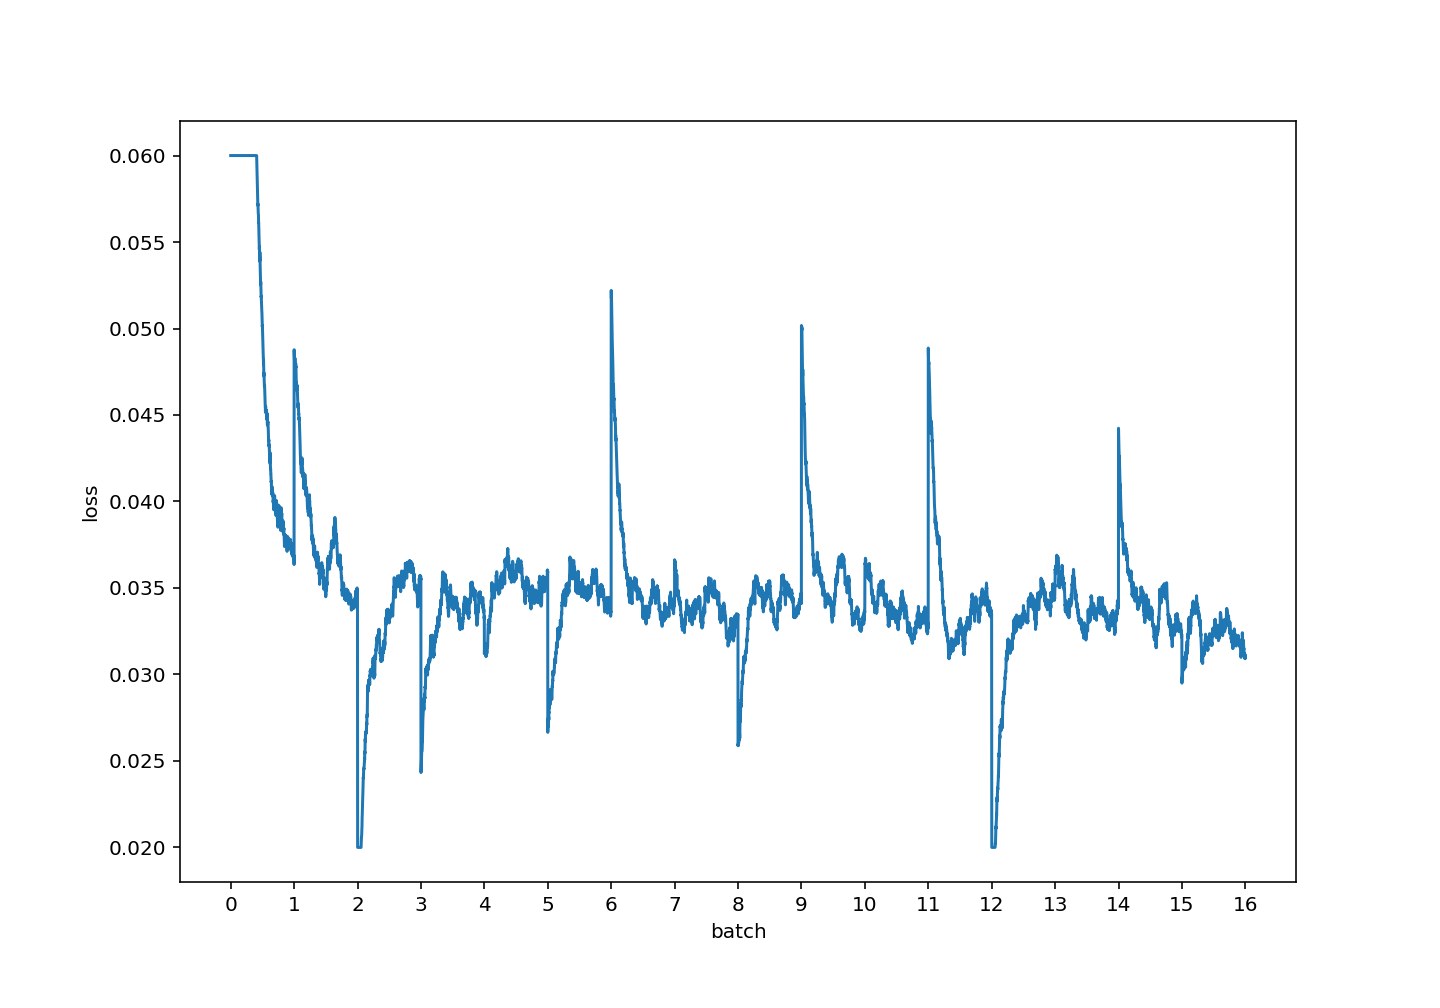

{'loss': 0.03635415313506277, 'mloss': tensor(0.0605), 'val_loss': 0.04349200989766588, 'val_mloss_tot': tensor(0.0754)}


{'loss': 0.03431799845710916, 'mloss': tensor(0.0591), 'val_loss': 0.04160740688842322, 'val_mloss_tot': tensor(0.0721)}


{'loss': 0.03554305141188108, 'mloss': tensor(0.0630), 'val_loss': 0.04115358079792794, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.03335093301609355, 'mloss': tensor(0.0556), 'val_loss': 0.041215710309815815, 'val_mloss_tot': tensor(0.0715)}


{'loss': 0.0359669382844029, 'mloss': tensor(0.0651), 'val_loss': 0.04243735637254279, 'val_mloss_tot': tensor(0.0736)}


{'loss': 0.033720373926601745, 'mloss': tensor(0.0583), 'val_loss': 0.04130904066142411, 'val_mloss_tot': tensor(0.0716)}


{'loss': 0.03447375348036154, 'mloss': tensor(0.0617), 'val_loss': 0.04110039636295454, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.033394811862625544, 'mloss': tensor(0.0590), 'val_loss': 0.04102570798794, 'val_mloss_tot': tensor(0.0711)}


{'loss': 0.034096198459671725, 'mloss': tensor(0.0596), 'val_loss': 0.04228010309717889, 'val_mloss_tot': tensor(0.0733)}


{'loss': 0.03390912650577671, 'mloss': tensor(0.0623), 'val_loss': 0.04164212059087391, 'val_mloss_tot': tensor(0.0722)}


{'loss': 0.03288706184612296, 'mloss': tensor(0.0572), 'val_loss': 0.04087763877351553, 'val_mloss_tot': tensor(0.0709)}


{'loss': 0.033502706377514874, 'mloss': tensor(0.0574), 'val_loss': 0.041198845903430446, 'val_mloss_tot': tensor(0.0714)}


{'loss': 0.03507642447069395, 'mloss': tensor(0.0630), 'val_loss': 0.04169940488101006, 'val_mloss_tot': tensor(0.0723)}


{'loss': 0.033892259277553745, 'mloss': tensor(0.0601), 'val_loss': 0.04111255915018872, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.03212732172041066, 'mloss': tensor(0.0542), 'val_loss': 0.04114859897455228, 'val_mloss_tot': tensor(0.0713)}


{'loss': 0.03096630701943566, 'mloss': tensor(0.0518), 'val_loss': 0.040959791913445065, 'val_mloss_tot': tensor(0.0710)}




(0.040747087600232636, {'val_loss': 0.040747087600232636, 'val_mloss_tot': tensor(0.0706)})


In [25]:
%matplotlib nbagg
model_name,version, num_split = 'Densenet201_3' , 'classifier_splits',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape
split_train = train_df[train_df.PID.isin(set(split_sid[splits[num_split][0]]))].SeriesI.unique()
split_validate =  train_df[train_df.PID.isin(set(split_sid[splits[num_split][1]]))].SeriesI.unique()

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=18
num_epochs=16
klr=1
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_validate,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
version=version+'_fullhead_resmodel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1,limits=[0.02,0.06])
num_train_optimization_steps = num_epochs*(len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//4,tau=0)
optimizer = BertAdam(model.parameters(),lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                best_average=3,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [26]:
pred_list=[]
pred_list_tmp=[]
for num_split in tqdm_notebook(range(3)):
    model_name,version = 'Densenet169_3' , 'classifier_splits'
    pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
    features=pickle.load(pickle_file)
    pickle_file.close()
    features=features.reshape(features.shape[0]//8,8,-1)

    model=ResModel(features.shape[-1])
    version=version+'_fullhead_resmodel'

    model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
    test_dataset=train_dataset=FullHeadDataset(test_df,
                                  test_df.SeriesI.unique(),
                                  features,
                                  'SeriesI',
                                  'ImagePositionZ')
    for i in tqdm_notebook(range(32),leave=False):
        pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
        pred_list_tmp.append(pred_list[-1])
pred169=torch.cat(pred_list_tmp,-1).mean(-1)

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [27]:
pred_list_tmp=[]
for num_split in tqdm_notebook(range(3)):
    model_name,version = 'Densenet161_3' , 'classifier_splits'
    pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
    features=pickle.load(pickle_file)
    pickle_file.close()
    features=features.reshape(features.shape[0]//8,8,-1)

    model=ResModel(features.shape[-1])
    version=version+'_fullhead_resmodel'

    model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
    test_dataset=train_dataset=FullHeadDataset(test_df,
                                  test_df.SeriesI.unique(),
                                  features,
                                  'SeriesI',
                                  'ImagePositionZ')
    for i in tqdm_notebook(range(32),leave=False):
        pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
        pred_list_tmp.append(pred_list[-1])
pred161=torch.cat(pred_list_tmp,-1).mean(-1)

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [28]:
pred_list_tmp=[]
for num_split in tqdm_notebook(range(3)):
    model_name,version = 'Densenet201_3' , 'classifier_splits'
    pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
    features=pickle.load(pickle_file)
    pickle_file.close()
    features=features.reshape(features.shape[0]//8,8,-1)

    model=ResModel(features.shape[-1])
    version=version+'_fullhead_resmodel'

    model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
    test_dataset=train_dataset=FullHeadDataset(test_df,
                                  test_df.SeriesI.unique(),
                                  features,
                                  'SeriesI',
                                  'ImagePositionZ')
    for i in tqdm_notebook(range(32),leave=False):
        pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
        pred_list_tmp.append(pred_list[-1])
pred201=torch.cat(pred_list_tmp,-1).mean(-1)

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [29]:
pred = torch.cat(pred_list,-1).mean(-1)

In [30]:
len(pred_list)

288

In [31]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

(78545,)

(78545, 6)

In [ ]:
len(pred_list)

In [ ]:
preds2=preds

In [ ]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape

features=features[np.where(~dup)]
features.shape[0]

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=4

#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_val,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=SimpleModel2(features.shape[-1])
num_epochs=13
version='basic_classifier_wso_tta'+'_fullhead_SimpleModel2'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [ ]:

model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)
version=version+'_tta_fullhead_SimpleModel2'
model=SimpleModel2(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(32)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
pred=torch.cat(pred_list,-1).mean(-1)

In [ ]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

In [ ]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

features=features.reshape(features.shape[0]//4,4,-1)
features.shape

features=features[np.where(~dup)]
features.shape[0]

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
batch_size=16
num_workers=2

#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_val,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

model=ResModel(features.shape[-1])
num_epochs=13
version='basic_classifier_wso_tta'+'_fullhead_ResModel'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.0005)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [ ]:

model_name,version, num_split = 'Densenet169_3' , 'basic_classifier_wso',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)
version=version+'_tta_fullhead_ResModel'
model=ResModel(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(32)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=128)[...,None])
pred=torch.cat(pred_list,-1).mean(-1)

In [ ]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

image_ids.shape

preds.shape

In [ ]:
preds1=preds

In [ ]:
preds=(preds1+preds2)/2

In [ ]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))

submission_df.head(12)
submission_df.shape
sub_num=37
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])

In [ ]:
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
version=version+'_fullhead'
model=SimpleModel(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=64)

In [ ]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds1=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

In [ ]:
preds0=preds


In [ ]:
preds=(preds0+preds1)/2

In [33]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))
submission_df.head(12)
submission_df.shape
sub_num=38
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,0.002140
1,ID_000012eaf_epidural,0.000062
2,ID_000012eaf_intraparenchymal,0.000272
3,ID_000012eaf_intraventricular,0.000039
4,ID_000012eaf_subarachnoid,0.000246
5,ID_000012eaf_subdural,0.001569
6,ID_0000ca2f6_any,0.001333
7,ID_0000ca2f6_epidural,0.000028
8,ID_0000ca2f6_intraparenchymal,0.000305
9,ID_0000ca2f6_intraventricular,0.000020


(471270, 2)

In [ ]:
%matplotlib nbagg
num_neighbors=3
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))